In [18]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import h5py

In [19]:
backframes = 3
test_split = 0.2

In [20]:
X = []
y = []
for i in range(10):
    filename = f"dataset/{i:03}.hdf5"
    with h5py.File(filename, "r") as file:
        gray = file['gray']
        size = min(gray.shape[1], gray.shape[2])
        gray = gray[:, :size, :size]
        depth = file['depth']
        depth = depth[:, :size, :size]
        for j in range(0, gray.shape[0] - backframes, backframes):
            X.append(gray[j:j + backframes])
            y.append(depth[j + backframes - 1])
X = tf.convert_to_tensor(X, dtype=tf.float16) / 255.0
y = tf.convert_to_tensor(y, dtype=tf.float16) / 255.0
        
X.shape, y.shape

(TensorShape([249, 3, 192, 192]), TensorShape([249, 192, 192]))

In [21]:
X_train = X[:-int(X.shape[0] * test_split)]
y_train = y[:-int(y.shape[0] * test_split)]

X_test = X[-int(X.shape[0] * test_split):]
y_test = y[-int(y.shape[0] * test_split):]

In [22]:
def custom_loss(y_true, y_pred):
    y_true = y_true[..., tf.newaxis]
    y_pred = y_pred[..., tf.newaxis]

    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
    weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

    # Depth smoothness
    smoothness_x = dx_pred * weights_x
    smoothness_y = dy_pred * weights_y

    depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
        abs(smoothness_y)
    )

    # Structural similarity (SSIM) index
    ssim_loss = tf.reduce_mean(
        1
        - tf.image.ssim(
            y_true, y_pred, max_val=size, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
        )
    )
    # Point-wise depth
    l1_loss = tf.reduce_mean(tf.abs(y_true - y_pred))

    loss = (
        (0.85 * ssim_loss)
        + (0.1 * l1_loss)
        + (0.9 * depth_smoothness_loss)
    )

    return loss

In [23]:
net = keras.Input(shape=X.shape[1:])
inputs = net

net = net[..., tf.newaxis]

net = net[:, -1, ...]

size_factor = 16

d = net = keras.layers.Conv2D(size_factor, 3, padding='same')(net)
net = keras.layers.BatchNormalization()(net)
net = keras.layers.LeakyReLU(alpha=0.2)(net)
net = keras.layers.Conv2D(size_factor, 3, padding='same')(net)
net = keras.layers.BatchNormalization()(net)
d1 = net = keras.layers.LeakyReLU(alpha=0.2)(net)
net += d
net = keras.layers.MaxPooling2D(2)(net)

d = net = keras.layers.Conv2D(size_factor*2, 3, padding='same')(net)
net = keras.layers.BatchNormalization()(net)
net = keras.layers.LeakyReLU(alpha=0.2)(net)
net = keras.layers.Conv2D(size_factor*2, 3, padding='same')(net)
net = keras.layers.BatchNormalization()(net)
d2 = net = keras.layers.LeakyReLU(alpha=0.2)(net)
net += d
net = keras.layers.MaxPooling2D(2)(net)

d = net = keras.layers.Conv2D(size_factor*4, 3, padding='same')(net)
net = keras.layers.BatchNormalization()(net)
net = keras.layers.LeakyReLU(alpha=0.2)(net)
net = keras.layers.Conv2D(size_factor*4, 3, padding='same')(net)
net = keras.layers.BatchNormalization()(net)
d3 = net = keras.layers.LeakyReLU(alpha=0.2)(net)
net += d
net = keras.layers.MaxPooling2D(2)(net)

d = net = keras.layers.Conv2D(size_factor*8, 3, padding='same')(net)
net = keras.layers.BatchNormalization()(net)
net = keras.layers.LeakyReLU(alpha=0.2)(net)
net = keras.layers.Conv2D(size_factor*8, 3, padding='same')(net)
net = keras.layers.BatchNormalization()(net)
d4 = net = keras.layers.LeakyReLU(alpha=0.2)(net)
net += d
net = keras.layers.MaxPooling2D(2)(net)



net = keras.layers.Conv2D(size_factor*16, 3, padding='same')(net)
net = keras.layers.LeakyReLU(alpha=0.2)(net)
net = keras.layers.Conv2D(size_factor*16, 3, padding='same')(net)
net = keras.layers.LeakyReLU(alpha=0.2)(net)



net = keras.layers.UpSampling2D(2)(net)
net = keras.layers.Conv2D(size_factor*8, 3, padding='same')(
    keras.layers.Concatenate()([net, d4])
)
net = keras.layers.BatchNormalization()(net)
net = keras.layers.LeakyReLU(alpha=0.2)(net)
net = keras.layers.Conv2D(size_factor*8, 3, padding='same')(net)
net = keras.layers.BatchNormalization()(net)
net = keras.layers.LeakyReLU(alpha=0.2)(net)

net = keras.layers.UpSampling2D(2)(net)
net = keras.layers.Conv2D(size_factor*4, 3, padding='same')(
    keras.layers.Concatenate()([net, d3])
)
net = keras.layers.BatchNormalization()(net)
net = keras.layers.LeakyReLU(alpha=0.2)(net)
net = keras.layers.Conv2D(size_factor*4, 3, padding='same')(net)
net = keras.layers.BatchNormalization()(net)
net = keras.layers.LeakyReLU(alpha=0.2)(net)

net = keras.layers.UpSampling2D(2)(net)
net = keras.layers.Conv2D(size_factor*2, 3, padding='same')(
    keras.layers.Concatenate()([net, d2])
)
net = keras.layers.BatchNormalization()(net)
net = keras.layers.LeakyReLU(alpha=0.2)(net)
net = keras.layers.Conv2D(size_factor*2, 3, padding='same')(net)
net = keras.layers.BatchNormalization()(net)
net = keras.layers.LeakyReLU(alpha=0.2)(net)

net = keras.layers.UpSampling2D(2)(net)
net = keras.layers.Conv2D(size_factor, 3, padding='same')(
    keras.layers.Concatenate()([net, d1])
)
net = keras.layers.BatchNormalization()(net)
net = keras.layers.LeakyReLU(alpha=0.2)(net)
net = keras.layers.Conv2D(size_factor, 3, padding='same')(net)
net = keras.layers.BatchNormalization()(net)
net = keras.layers.LeakyReLU(alpha=0.2)(net)



net = keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(net)

net = net[..., 0]
outputs = net

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.legacy.Adam(
        learning_rate=0.0002,
        amsgrad=False,    
    ),
    loss=custom_loss,
)

In [28]:
model.fit(
    X_train,
    y_train,
    epochs=30,
    validation_data=(X_test, y_test),
    shuffle=True,
)

Epoch 1/30
7/7 [==============================] - 20s 3s/step - loss: 0.1200 - val_loss: 0.1352
Epoch 2/30
7/7 [==============================] - 20s 3s/step - loss: 0.1129 - val_loss: 0.1270
Epoch 3/30
7/7 [==============================] - 20s 3s/step - loss: 0.1166 - val_loss: 0.1301
Epoch 4/30
7/7 [==============================] - 20s 3s/step - loss: 0.1184 - val_loss: 0.1246
Epoch 5/30
7/7 [==============================] - 20s 3s/step - loss: 0.1146 - val_loss: 0.1243
Epoch 6/30
7/7 [==============================] - 20s 3s/step - loss: 0.1123 - val_loss: 0.1220
Epoch 7/30
7/7 [==============================] - 20s 3s/step - loss: 0.1203 - val_loss: 0.1267
Epoch 8/30
7/7 [==============================] - 20s 3s/step - loss: 0.1196 - val_loss: 0.1191
Epoch 9/30
7/7 [==============================] - 20s 3s/step - loss: 0.1136 - val_loss: 0.1366
Epoch 10/30
7/7 [==============================] - 20s 3s/step - loss: 0.1088 - val_loss: 0.1470
Epoch 11/30
7/7 [======================

In [41]:
test_index = 0
gray_frames = X_train[test_index]
depth = y_train[test_index]

In [42]:
prediction = model.predict(gray_frames[tf.newaxis, ...])[0]

1/1 [==============================] - 0s 108ms/step


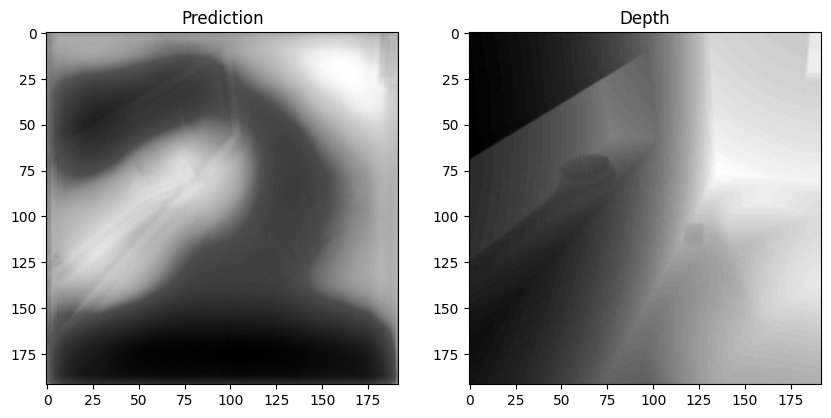

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(prediction, cmap='gray')
axs[0].set_title('Prediction')

axs[1].imshow(depth, cmap='gray')
axs[1].set_title('Depth')

plt.show()